In [17]:
import os
from pathlib import Path
from typing import Callable, Optional, List, Tuple

from PIL import Image
from torch.utils.data import Dataset

# Canonical class order (you can change if you prefer a different label order)
CLASS_TO_IDX = {"male": 0, "female": 1}
IDX_TO_CLASS = {0:"male",1:"female"}


In [18]:
import torchvision.transforms as transforms

class GenderDataset(Dataset):
   
    def __init__(
        self,
        root: str | Path,
        split: str = "train",
        transform: Optional[Callable] = None,
        extensions: Tuple[str, ...] = (".png", ".jpg", ".jpeg"),
    ):
        self.root = Path(root)
        self.split = split
        self.transform = transform
        self.extensions = tuple(e.lower() for e in extensions)

        self.samples = self._load_from_dirs()

    def _load_from_dirs(self) -> List[Tuple[Path, int]]:
        split_dir = self.root / self.split
        if not split_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {split_dir}")

        samples: List[Tuple[Path, int]] = []
        for class_name, idx in CLASS_TO_IDX.items():
            class_dir = split_dir / class_name
            if not class_dir.exists():
                # Allow missing class folders (but warn via comment)
                print(f"Warning: class folder missing: {class_dir}")
                continue
            for p in class_dir.rglob("*"):
                if p.is_file() and p.suffix.lower() in self.extensions:
                    samples.append((p, idx))
        return samples


    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int):
        path, target = self.samples[index]
        img = Image.open(path).convert("RGB")  # dataset is RGB PNGs
        if self.transform is not None:
            img = self.transform(img)
        return img, target

In [19]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),   # ResNet expects 224x224
    transforms.Grayscale(num_output_channels=3),  # for MNIST, remove if dataset is already RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [20]:
train_dataset = GenderDataset(
    root='Gender01',
    split='train',
    transform=transform

)
test_dataset = GenderDataset(
    root='Gender01',
    split='test',
    transform=transform
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].


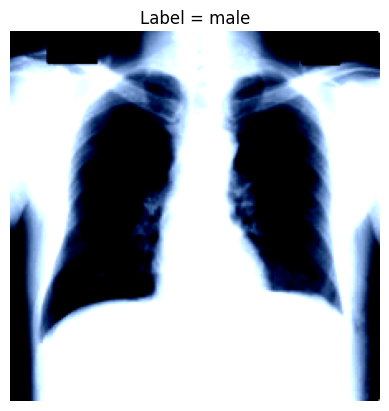

[(PosixPath('Gender01/train/male/JPCLN094.png'), 0), (PosixPath('Gender01/train/male/JPCLN123.png'), 0), (PosixPath('Gender01/train/male/JPCLN083.png'), 0), (PosixPath('Gender01/train/male/JPCLN097.png'), 0), (PosixPath('Gender01/train/male/JPCLN068.png'), 0), (PosixPath('Gender01/train/male/JPCLN040.png'), 0), (PosixPath('Gender01/train/male/JPCLN120.png'), 0), (PosixPath('Gender01/train/male/JPCLN121.png'), 0), (PosixPath('Gender01/train/male/JPCLN135.png'), 0), (PosixPath('Gender01/train/male/JPCLN041.png'), 0), (PosixPath('Gender01/train/male/JPCLN086.png'), 0), (PosixPath('Gender01/train/male/JPCLN092.png'), 0), (PosixPath('Gender01/train/male/JPCLN045.png'), 0), (PosixPath('Gender01/train/male/JPCLN118.png'), 0), (PosixPath('Gender01/train/male/JPCLN130.png'), 0), (PosixPath('Gender01/train/male/JPCLN078.png'), 0), (PosixPath('Gender01/train/male/JPCLN044.png'), 0), (PosixPath('Gender01/train/male/JPCLN093.png'), 0), (PosixPath('Gender01/train/male/JPCLN087.png'), 0), (PosixPath(

In [21]:
img, label = train_dataset[0]

import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))   # convert CHW → HWC
plt.title(f"Label = {IDX_TO_CLASS[label]}")
plt.axis("off")
plt.show()
print(train_dataset.samples)

In [22]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from tqdm import tqdm

def test(model, test_loader, device):
    model.eval()  # evaluation mode (no dropout, no BN updates)
    correct = 0
    total = 0
    test_loss = 0.0

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():  # no gradients needed
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # predicted class = index with max logit
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"✅ Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy

num_epochs = 2

def train(num_epochs, model, train_loader, test_loader):
    
    total_step = len( train_loader)
    epoch_losses = []   # store average loss per epoch
    test_losses = []
    test_accuracies = []
    for epoch in range(num_epochs):
        
        running_loss = 0.0
        for i, (imgs, labels) in tqdm(enumerate(train_loader)):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)          # backbone forward has no grads (requires_grad=False)
            loss = criterion(outputs, labels)
            loss.backward()                # grads flow only through model.fc
            optimizer.step()
            if (i+1) % 50 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1,
                              total_step, loss.item()))

            running_loss += loss.item()

        avg_loss = running_loss / total_step
        epoch_losses.append(avg_loss)
        epoch_test_loss,accuracy = test(model,test_loader,device)
        test_losses.append(epoch_test_loss)
        test_accuracies.append(accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")

    # plot epoch vs loss
    plt.plot(range(1, num_epochs+1), epoch_losses, marker='o',label="Training Loss")
    plt.plot(range(1, num_epochs+1), test_losses, marker='s', label = "Testing Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss vs Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

     # plot epoch vs loss
    plt.plot(range(1, num_epochs+1), test_accuracies, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Test Accuracy')
    plt.grid(True)
    plt.show()

    return epoch_losses





In [23]:
import torch
from torch.utils.data import DataLoader

# sensible defaults
BATCH_SIZE = 32
IS_TRAIN = True

# tip: on Mac M1 use num_workers=0; on Linux/GPU you can raise it (e.g., 4)
num_workers = 0  # set to 4–8 on Linux if you want

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # shuffle for training
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
    drop_last=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # no shuffle for eval
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
    drop_last=False,
)

# --- quick sanity check ---
imgs, labels = next(iter(train_loader))
print("Train batch:", imgs.shape, labels.shape)  # e.g., torch.Size([64, 3, 128, 128]) torch.Size([64])



Train batch: torch.Size([32, 3, 224, 224]) torch.Size([32])


model

In [24]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Trainable params: 2,360,322 / 11,177,538


5it [00:01,  2.71it/s]


✅ Test Loss: 0.6989, Test Accuracy: 56.99%
Epoch [1/50] Average Loss: 0.7561


5it [00:00,  6.64it/s]


✅ Test Loss: 0.6987, Test Accuracy: 54.84%
Epoch [2/50] Average Loss: 0.6929


5it [00:00,  6.79it/s]


✅ Test Loss: 0.6567, Test Accuracy: 61.29%
Epoch [3/50] Average Loss: 0.6715


5it [00:00,  6.84it/s]


✅ Test Loss: 0.6306, Test Accuracy: 69.89%
Epoch [4/50] Average Loss: 0.6350


5it [00:04,  1.18it/s]


✅ Test Loss: 0.6092, Test Accuracy: 69.89%
Epoch [5/50] Average Loss: 0.6165


5it [00:00,  6.62it/s]


✅ Test Loss: 0.5952, Test Accuracy: 75.27%
Epoch [6/50] Average Loss: 0.5890


5it [00:00,  6.84it/s]


✅ Test Loss: 0.5840, Test Accuracy: 70.97%
Epoch [7/50] Average Loss: 0.5670


5it [00:00,  7.25it/s]


✅ Test Loss: 0.5649, Test Accuracy: 75.27%
Epoch [8/50] Average Loss: 0.5429


5it [00:00,  7.41it/s]


✅ Test Loss: 0.5508, Test Accuracy: 79.57%
Epoch [9/50] Average Loss: 0.5209


5it [00:00,  7.05it/s]


✅ Test Loss: 0.5347, Test Accuracy: 80.65%
Epoch [10/50] Average Loss: 0.5020


5it [00:00,  5.59it/s]


✅ Test Loss: 0.5237, Test Accuracy: 82.80%
Epoch [11/50] Average Loss: 0.4829


5it [00:00,  6.91it/s]


✅ Test Loss: 0.5144, Test Accuracy: 82.80%
Epoch [12/50] Average Loss: 0.4658


5it [00:00,  7.18it/s]


✅ Test Loss: 0.4994, Test Accuracy: 81.72%
Epoch [13/50] Average Loss: 0.4470


5it [00:00,  6.21it/s]


✅ Test Loss: 0.4872, Test Accuracy: 83.87%
Epoch [14/50] Average Loss: 0.4315


5it [00:00,  6.59it/s]


✅ Test Loss: 0.4761, Test Accuracy: 84.95%
Epoch [15/50] Average Loss: 0.4165


5it [00:00,  7.34it/s]


✅ Test Loss: 0.4710, Test Accuracy: 82.80%
Epoch [16/50] Average Loss: 0.3987


5it [00:00,  7.25it/s]


✅ Test Loss: 0.4633, Test Accuracy: 83.87%
Epoch [17/50] Average Loss: 0.3861


5it [00:00,  7.15it/s]


✅ Test Loss: 0.4520, Test Accuracy: 86.02%
Epoch [18/50] Average Loss: 0.3711


5it [00:00,  7.40it/s]


✅ Test Loss: 0.4426, Test Accuracy: 86.02%
Epoch [19/50] Average Loss: 0.3610


5it [00:00,  7.45it/s]


✅ Test Loss: 0.4370, Test Accuracy: 87.10%
Epoch [20/50] Average Loss: 0.3476


5it [00:00,  7.38it/s]


✅ Test Loss: 0.4293, Test Accuracy: 89.25%
Epoch [21/50] Average Loss: 0.3333


5it [00:00,  7.15it/s]


✅ Test Loss: 0.4222, Test Accuracy: 89.25%
Epoch [22/50] Average Loss: 0.3249


5it [00:00,  6.92it/s]


✅ Test Loss: 0.4162, Test Accuracy: 89.25%
Epoch [23/50] Average Loss: 0.3154


5it [00:00,  6.48it/s]


✅ Test Loss: 0.4165, Test Accuracy: 86.02%
Epoch [24/50] Average Loss: 0.3074


5it [00:00,  5.48it/s]


✅ Test Loss: 0.4076, Test Accuracy: 90.32%
Epoch [25/50] Average Loss: 0.2951


5it [00:00,  6.48it/s]


✅ Test Loss: 0.4015, Test Accuracy: 90.32%
Epoch [26/50] Average Loss: 0.2881


5it [00:00,  6.48it/s]


✅ Test Loss: 0.3962, Test Accuracy: 90.32%
Epoch [27/50] Average Loss: 0.2773


5it [00:00,  5.75it/s]


✅ Test Loss: 0.3932, Test Accuracy: 90.32%
Epoch [28/50] Average Loss: 0.2651


5it [00:00,  5.44it/s]


✅ Test Loss: 0.3928, Test Accuracy: 90.32%
Epoch [29/50] Average Loss: 0.2608


5it [00:00,  6.74it/s]


✅ Test Loss: 0.3866, Test Accuracy: 90.32%
Epoch [30/50] Average Loss: 0.2510


5it [00:00,  7.32it/s]


✅ Test Loss: 0.3824, Test Accuracy: 90.32%
Epoch [31/50] Average Loss: 0.2431


5it [00:00,  7.23it/s]


✅ Test Loss: 0.3779, Test Accuracy: 90.32%
Epoch [32/50] Average Loss: 0.2378


5it [00:00,  7.32it/s]


✅ Test Loss: 0.3762, Test Accuracy: 90.32%
Epoch [33/50] Average Loss: 0.2301


5it [00:00,  6.73it/s]


✅ Test Loss: 0.3752, Test Accuracy: 91.40%
Epoch [34/50] Average Loss: 0.2221


5it [00:00,  7.35it/s]


✅ Test Loss: 0.3744, Test Accuracy: 90.32%
Epoch [35/50] Average Loss: 0.2183


5it [00:00,  7.07it/s]


✅ Test Loss: 0.3677, Test Accuracy: 90.32%
Epoch [36/50] Average Loss: 0.2114


5it [00:00,  7.36it/s]


✅ Test Loss: 0.3646, Test Accuracy: 90.32%
Epoch [37/50] Average Loss: 0.2104


5it [00:00,  5.34it/s]


✅ Test Loss: 0.3639, Test Accuracy: 91.40%
Epoch [38/50] Average Loss: 0.1992


5it [00:00,  5.20it/s]


✅ Test Loss: 0.3665, Test Accuracy: 90.32%
Epoch [39/50] Average Loss: 0.1948


5it [00:00,  7.33it/s]


✅ Test Loss: 0.3612, Test Accuracy: 91.40%
Epoch [40/50] Average Loss: 0.1884


5it [00:00,  5.92it/s]


✅ Test Loss: 0.3583, Test Accuracy: 91.40%
Epoch [41/50] Average Loss: 0.1865


5it [00:00,  7.27it/s]


✅ Test Loss: 0.3573, Test Accuracy: 91.40%
Epoch [42/50] Average Loss: 0.1797


5it [00:00,  7.52it/s]


✅ Test Loss: 0.3568, Test Accuracy: 91.40%
Epoch [43/50] Average Loss: 0.1729


5it [00:00,  7.32it/s]


✅ Test Loss: 0.3551, Test Accuracy: 91.40%
Epoch [44/50] Average Loss: 0.1715


5it [00:00,  6.84it/s]


✅ Test Loss: 0.3538, Test Accuracy: 91.40%
Epoch [45/50] Average Loss: 0.1650


5it [00:00,  7.41it/s]


✅ Test Loss: 0.3525, Test Accuracy: 91.40%
Epoch [46/50] Average Loss: 0.1609


5it [00:00,  6.98it/s]


✅ Test Loss: 0.3520, Test Accuracy: 91.40%
Epoch [47/50] Average Loss: 0.1580


5it [00:00,  7.29it/s]


✅ Test Loss: 0.3514, Test Accuracy: 91.40%
Epoch [48/50] Average Loss: 0.1516


5it [00:00,  7.48it/s]


✅ Test Loss: 0.3501, Test Accuracy: 91.40%
Epoch [49/50] Average Loss: 0.1509


5it [00:00,  7.36it/s]


✅ Test Loss: 0.3521, Test Accuracy: 91.40%
Epoch [50/50] Average Loss: 0.1476


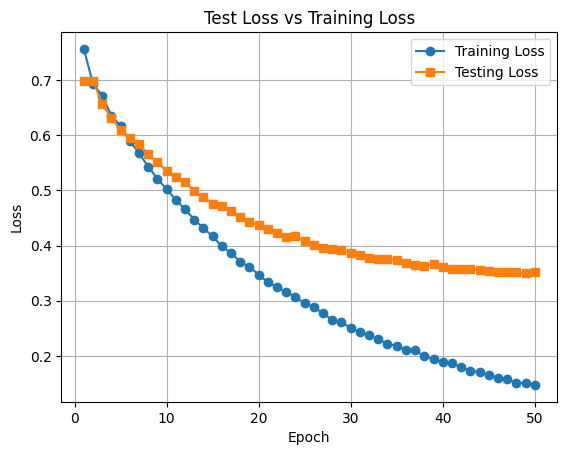

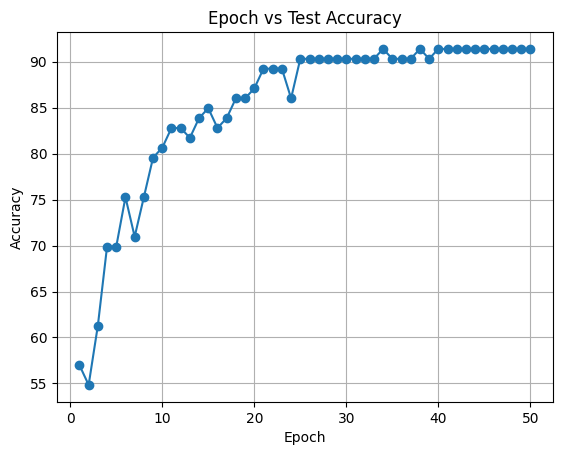

[0.7560556411743165,
 0.6928965449333191,
 0.6715296387672425,
 0.6349762320518494,
 0.6164551019668579,
 0.5889914274215698,
 0.566999638080597,
 0.5428959369659424,
 0.5209390461444855,
 0.5020116686820983,
 0.48285490870475767,
 0.46582105159759524,
 0.4470431447029114,
 0.4314832270145416,
 0.41648343205451965,
 0.3986851334571838,
 0.3861010789871216,
 0.37105453610420225,
 0.3609801948070526,
 0.3475626349449158,
 0.3333093047142029,
 0.3248796105384827,
 0.3153768241405487,
 0.3074289679527283,
 0.29508969783782957,
 0.2881236791610718,
 0.2773427367210388,
 0.2651390552520752,
 0.2607927143573761,
 0.25095642507076266,
 0.24306421875953674,
 0.2378285974264145,
 0.2301337957382202,
 0.22208679020404815,
 0.2182941973209381,
 0.21139091849327088,
 0.21038802862167358,
 0.19918083548545837,
 0.19484307765960693,
 0.18842685222625732,
 0.18652236461639404,
 0.17972203493118286,
 0.17289311587810516,
 0.1715226948261261,
 0.1650136947631836,
 0.16090440452098848,
 0.158034053444862

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# --- 1) Load backbone ---
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# --- 2) Replace final head (your task: 2 classes here) ---
num_classes = 2
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, num_classes)   # head is trainable

# --- 3) Freeze EVERYTHING first ---
for p in model.parameters():
    p.requires_grad = False

# --- 4) Unfreeze ONLY the last conv and the final FC ---
# ResNet-18 uses BasicBlock with conv1/conv2; "last conv" = layer4[-1].conv2
last_conv = model.layer4[-1].conv2
for p in last_conv.parameters():
    p.requires_grad = True

for p in model.fc.parameters():
    p.requires_grad = True

model = model.to(device)

# --- 5) Keep BN stats frozen (global eval), but train the two modules we care about ---
model.eval()            # freeze BN running stats across the net
last_conv.train()       # allow grads in last conv
model.fc.train()        # allow grads in classifier

# --- 6) Loss & optimizer (only the unfrozen params) ---
criterion = nn.CrossEntropyLoss()

# You can use param groups (often a smaller LR for conv, larger for new head):
optimizer = optim.Adam(
    [
        {"params": last_conv.parameters(), "lr": 1e-5},
        {"params": model.fc.parameters(), "lr": 1e-4},
    ],
    weight_decay=1e-4,
)

# (Optional) sanity check: which params are trainable?
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,}")

# --- 7) Train ---
# IMPORTANT: if your train() calls model.train() globally,
# re-freeze BN each epoch/step:
#   for m in model.modules():
#       if isinstance(m, nn.BatchNorm2d):
#           m.eval()
# Or keep your loop from switching the whole model to train().
train(50, model, train_loader, test_loader)


In [15]:
from pytorch_grad_cam import DeepFeatureFactorization
from pytorch_grad_cam.utils.image import show_factorization_on_image

model = model.to("cpu")
input_tensor = test_dataset[0][0].unsqueeze(0).to("cpu")
dff = DeepFeatureFactorization(model=model, target_layer=model.layer4, computation_on_concepts=model.fc)
concepts, batch_explanations, concept_scores = dff(input_tensor, 1)
rgb_img_float = img.numpy().transpose(1,2,0)

visualization_2 = show_factorization_on_image(rgb_img_float, 
                                            batch_explanations[0],
                                            image_weight=0.3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].


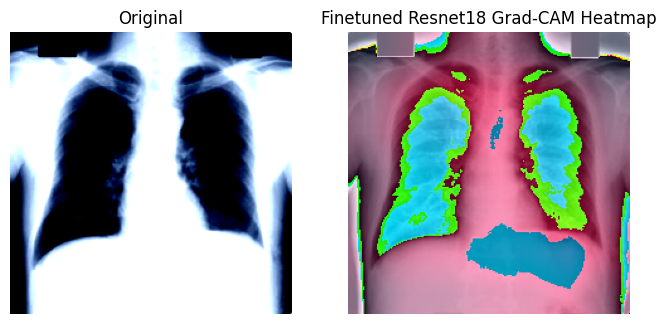

In [16]:
# Show results
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(rgb_img_float)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(visualization_2, cmap='jet')
axes[1].set_title("Finetuned Resnet18 Grad-CAM Heatmap")
axes[1].axis("off")

plt.show()

5it [00:00,  5.26it/s]


✅ Test Loss: 0.7003, Test Accuracy: 52.69%
Epoch [1/40] Average Loss: 0.7369


5it [00:00,  5.96it/s]


✅ Test Loss: 0.6327, Test Accuracy: 63.44%
Epoch [2/40] Average Loss: 0.6765


5it [00:00,  7.00it/s]


✅ Test Loss: 0.6027, Test Accuracy: 76.34%
Epoch [3/40] Average Loss: 0.6079


5it [00:00,  7.69it/s]


✅ Test Loss: 0.5691, Test Accuracy: 79.57%
Epoch [4/40] Average Loss: 0.5646


5it [00:00,  7.73it/s]


✅ Test Loss: 0.5364, Test Accuracy: 75.27%
Epoch [5/40] Average Loss: 0.5334


5it [00:00,  7.17it/s]


✅ Test Loss: 0.5506, Test Accuracy: 75.27%
Epoch [6/40] Average Loss: 0.5360


5it [00:00,  7.97it/s]


✅ Test Loss: 0.5014, Test Accuracy: 76.34%
Epoch [7/40] Average Loss: 0.4545


5it [00:00,  7.90it/s]


✅ Test Loss: 0.4772, Test Accuracy: 79.57%
Epoch [8/40] Average Loss: 0.4559


5it [00:00,  8.08it/s]


✅ Test Loss: 0.4822, Test Accuracy: 83.87%
Epoch [9/40] Average Loss: 0.4036


5it [00:01,  3.68it/s]


✅ Test Loss: 0.4537, Test Accuracy: 84.95%
Epoch [10/40] Average Loss: 0.4008


5it [00:00,  6.74it/s]


✅ Test Loss: 0.4480, Test Accuracy: 80.65%
Epoch [11/40] Average Loss: 0.3824


5it [00:00,  6.55it/s]


✅ Test Loss: 0.4402, Test Accuracy: 82.80%
Epoch [12/40] Average Loss: 0.3628


5it [00:00,  7.41it/s]


✅ Test Loss: 0.4238, Test Accuracy: 84.95%
Epoch [13/40] Average Loss: 0.3452


5it [00:00,  7.42it/s]


✅ Test Loss: 0.4160, Test Accuracy: 84.95%
Epoch [14/40] Average Loss: 0.3304


5it [00:00,  7.20it/s]


✅ Test Loss: 0.4102, Test Accuracy: 86.02%
Epoch [15/40] Average Loss: 0.3224


5it [00:00,  7.94it/s]


✅ Test Loss: 0.4068, Test Accuracy: 86.02%
Epoch [16/40] Average Loss: 0.3071


5it [00:00,  7.46it/s]


✅ Test Loss: 0.3994, Test Accuracy: 84.95%
Epoch [17/40] Average Loss: 0.3003


5it [00:00,  8.04it/s]


✅ Test Loss: 0.3945, Test Accuracy: 86.02%
Epoch [18/40] Average Loss: 0.2890


5it [00:00,  8.04it/s]


✅ Test Loss: 0.3906, Test Accuracy: 86.02%
Epoch [19/40] Average Loss: 0.2760


5it [00:00,  8.12it/s]


✅ Test Loss: 0.3874, Test Accuracy: 84.95%
Epoch [20/40] Average Loss: 0.2698


5it [00:00,  8.19it/s]


✅ Test Loss: 0.3840, Test Accuracy: 87.10%
Epoch [21/40] Average Loss: 0.2648


5it [00:00,  7.93it/s]


✅ Test Loss: 0.3814, Test Accuracy: 87.10%
Epoch [22/40] Average Loss: 0.2610


5it [00:00,  8.05it/s]


✅ Test Loss: 0.3787, Test Accuracy: 88.17%
Epoch [23/40] Average Loss: 0.2519


5it [00:00,  8.11it/s]


✅ Test Loss: 0.3768, Test Accuracy: 86.02%
Epoch [24/40] Average Loss: 0.2441


5it [00:00,  7.91it/s]


✅ Test Loss: 0.3735, Test Accuracy: 86.02%
Epoch [25/40] Average Loss: 0.2421


5it [00:00,  7.74it/s]


✅ Test Loss: 0.3720, Test Accuracy: 88.17%
Epoch [26/40] Average Loss: 0.2293


5it [00:00,  7.96it/s]


✅ Test Loss: 0.3690, Test Accuracy: 87.10%
Epoch [27/40] Average Loss: 0.2252


5it [00:00,  8.05it/s]


✅ Test Loss: 0.3684, Test Accuracy: 86.02%
Epoch [28/40] Average Loss: 0.2188


5it [00:00,  8.09it/s]


✅ Test Loss: 0.3655, Test Accuracy: 88.17%
Epoch [29/40] Average Loss: 0.2153


5it [00:00,  8.02it/s]


✅ Test Loss: 0.3644, Test Accuracy: 86.02%
Epoch [30/40] Average Loss: 0.2126


5it [00:00,  8.07it/s]


✅ Test Loss: 0.3638, Test Accuracy: 84.95%
Epoch [31/40] Average Loss: 0.2119


5it [00:00,  7.98it/s]


✅ Test Loss: 0.3623, Test Accuracy: 89.25%
Epoch [32/40] Average Loss: 0.1985


5it [00:00,  8.14it/s]


✅ Test Loss: 0.3610, Test Accuracy: 89.25%
Epoch [33/40] Average Loss: 0.1985


5it [00:00,  8.08it/s]


✅ Test Loss: 0.3598, Test Accuracy: 86.02%
Epoch [34/40] Average Loss: 0.1914


5it [00:00,  6.89it/s]


✅ Test Loss: 0.3603, Test Accuracy: 86.02%
Epoch [35/40] Average Loss: 0.1893


5it [00:00,  7.09it/s]


✅ Test Loss: 0.3587, Test Accuracy: 89.25%
Epoch [36/40] Average Loss: 0.1853


5it [00:00,  6.96it/s]


✅ Test Loss: 0.3567, Test Accuracy: 86.02%
Epoch [37/40] Average Loss: 0.1809


5it [00:00,  6.96it/s]


✅ Test Loss: 0.3595, Test Accuracy: 86.02%
Epoch [38/40] Average Loss: 0.1810


5it [00:00,  7.56it/s]


✅ Test Loss: 0.3552, Test Accuracy: 88.17%
Epoch [39/40] Average Loss: 0.1775


5it [00:00,  7.68it/s]


✅ Test Loss: 0.3551, Test Accuracy: 87.10%
Epoch [40/40] Average Loss: 0.1724


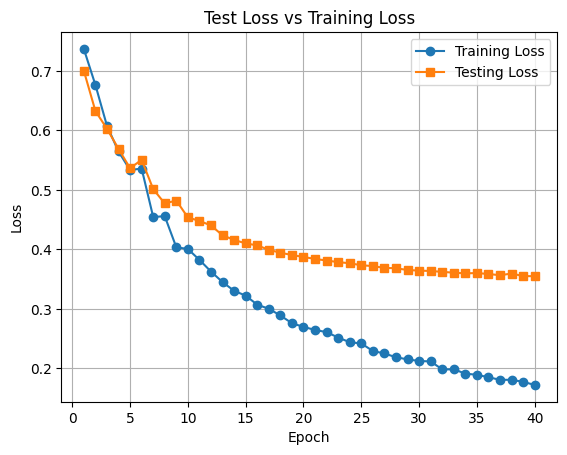

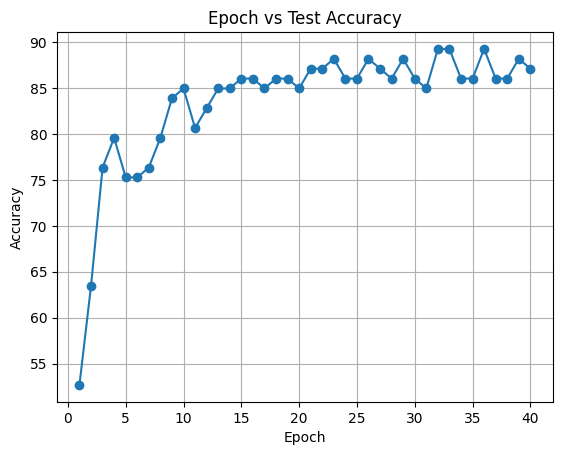

[0.7369164109230042,
 0.676524543762207,
 0.6078701734542846,
 0.564589524269104,
 0.5333748817443847,
 0.5359782934188843,
 0.4545270144939423,
 0.45585258603096007,
 0.4036051630973816,
 0.40079984068870544,
 0.3824434220790863,
 0.3628203570842743,
 0.3451512098312378,
 0.3304287314414978,
 0.3223898410797119,
 0.30713661909103396,
 0.30031580924987794,
 0.28904672861099245,
 0.27603723108768463,
 0.26983087360858915,
 0.26475470662117007,
 0.2610465198755264,
 0.25191918313503264,
 0.24409431219100952,
 0.24207352101802826,
 0.2293379694223404,
 0.2252143532037735,
 0.21883357763290406,
 0.21531983315944672,
 0.21255049407482146,
 0.2118573695421219,
 0.1984707772731781,
 0.19854489862918853,
 0.19138640761375428,
 0.18934484124183654,
 0.18528241515159607,
 0.18091280162334442,
 0.18096152544021607,
 0.17746807336807252,
 0.17235704958438874]

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze ALL pretrained weights
for p in model.parameters():
    p.requires_grad = False

# Replace final FC for our task
num_classes = 2
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, num_classes)   # this layer is trainable by default

model = model.to(device)

# IMPORTANT: keep backbone in eval mode so BatchNorm running stats don't update
model.eval()            # sets all to eval
model.fc.train()        # but we DO want the new head to train

# ----- Loss & optimizer (only update the new head) -----
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

train(40, model, train_loader, test_loader)

5it [00:02,  2.24it/s]


✅ Test Loss: 1.0849, Test Accuracy: 45.16%
Epoch [1/100] Average Loss: 0.8000


5it [00:01,  3.30it/s]


✅ Test Loss: 0.6380, Test Accuracy: 55.91%
Epoch [2/100] Average Loss: 0.7433


5it [00:01,  3.45it/s]


✅ Test Loss: 0.5848, Test Accuracy: 77.42%
Epoch [3/100] Average Loss: 0.5898


5it [00:01,  3.43it/s]


✅ Test Loss: 0.5359, Test Accuracy: 74.19%
Epoch [4/100] Average Loss: 0.4885


5it [00:01,  3.46it/s]


✅ Test Loss: 0.4420, Test Accuracy: 86.02%
Epoch [5/100] Average Loss: 0.3779


5it [00:01,  3.52it/s]


✅ Test Loss: 0.3953, Test Accuracy: 86.02%
Epoch [6/100] Average Loss: 0.2809


5it [00:01,  3.48it/s]


✅ Test Loss: 0.3450, Test Accuracy: 88.17%
Epoch [7/100] Average Loss: 0.2073


5it [00:01,  3.47it/s]


✅ Test Loss: 0.3265, Test Accuracy: 86.02%
Epoch [8/100] Average Loss: 0.1429


5it [00:01,  3.51it/s]


✅ Test Loss: 0.3299, Test Accuracy: 84.95%
Epoch [9/100] Average Loss: 0.0992


5it [00:01,  3.55it/s]


✅ Test Loss: 0.3083, Test Accuracy: 84.95%
Epoch [10/100] Average Loss: 0.0716


5it [00:01,  3.55it/s]


✅ Test Loss: 0.3061, Test Accuracy: 86.02%
Epoch [11/100] Average Loss: 0.0519


5it [00:01,  3.47it/s]


✅ Test Loss: 0.3392, Test Accuracy: 84.95%
Epoch [12/100] Average Loss: 0.0373


5it [00:01,  3.52it/s]


✅ Test Loss: 0.2956, Test Accuracy: 90.32%
Epoch [13/100] Average Loss: 0.0245


5it [00:01,  3.52it/s]


✅ Test Loss: 0.3810, Test Accuracy: 83.87%
Epoch [14/100] Average Loss: 0.0196


5it [00:01,  3.51it/s]


✅ Test Loss: 0.3150, Test Accuracy: 88.17%
Epoch [15/100] Average Loss: 0.0138


5it [00:01,  3.50it/s]


✅ Test Loss: 0.3197, Test Accuracy: 88.17%
Epoch [16/100] Average Loss: 0.0098


5it [00:01,  3.54it/s]


✅ Test Loss: 0.3565, Test Accuracy: 84.95%
Epoch [17/100] Average Loss: 0.0071


5it [00:01,  3.33it/s]


✅ Test Loss: 0.3567, Test Accuracy: 84.95%
Epoch [18/100] Average Loss: 0.0065


5it [00:01,  3.55it/s]


✅ Test Loss: 0.3340, Test Accuracy: 88.17%
Epoch [19/100] Average Loss: 0.0053


5it [00:01,  3.43it/s]


✅ Test Loss: 0.3528, Test Accuracy: 87.10%
Epoch [20/100] Average Loss: 0.0045


5it [00:01,  3.58it/s]


✅ Test Loss: 0.3672, Test Accuracy: 86.02%
Epoch [21/100] Average Loss: 0.0038


5it [00:01,  3.30it/s]


✅ Test Loss: 0.3563, Test Accuracy: 87.10%
Epoch [22/100] Average Loss: 0.0034


5it [00:01,  3.51it/s]


✅ Test Loss: 0.3623, Test Accuracy: 87.10%
Epoch [23/100] Average Loss: 0.0030


5it [00:01,  3.56it/s]


✅ Test Loss: 0.3685, Test Accuracy: 87.10%
Epoch [24/100] Average Loss: 0.0027


5it [00:04,  1.09it/s]


✅ Test Loss: 0.3695, Test Accuracy: 87.10%
Epoch [25/100] Average Loss: 0.0024


5it [00:01,  3.29it/s]


✅ Test Loss: 0.3802, Test Accuracy: 86.02%
Epoch [26/100] Average Loss: 0.0024


5it [00:01,  3.14it/s]


✅ Test Loss: 0.3707, Test Accuracy: 87.10%
Epoch [27/100] Average Loss: 0.0021


5it [00:01,  3.38it/s]


✅ Test Loss: 0.3698, Test Accuracy: 87.10%
Epoch [28/100] Average Loss: 0.0019


5it [00:01,  3.23it/s]


✅ Test Loss: 0.3772, Test Accuracy: 87.10%
Epoch [29/100] Average Loss: 0.0018


5it [00:01,  3.56it/s]


✅ Test Loss: 0.3797, Test Accuracy: 87.10%
Epoch [30/100] Average Loss: 0.0016


5it [00:01,  3.47it/s]


✅ Test Loss: 0.3867, Test Accuracy: 87.10%
Epoch [31/100] Average Loss: 0.0015


5it [00:01,  2.92it/s]


✅ Test Loss: 0.3884, Test Accuracy: 87.10%
Epoch [32/100] Average Loss: 0.0014


5it [00:01,  3.46it/s]


✅ Test Loss: 0.3873, Test Accuracy: 87.10%
Epoch [33/100] Average Loss: 0.0013


5it [00:01,  2.59it/s]


✅ Test Loss: 0.3890, Test Accuracy: 87.10%
Epoch [34/100] Average Loss: 0.0012


5it [00:01,  3.54it/s]


✅ Test Loss: 0.3881, Test Accuracy: 87.10%
Epoch [35/100] Average Loss: 0.0012


5it [00:01,  3.37it/s]


✅ Test Loss: 0.3879, Test Accuracy: 88.17%
Epoch [36/100] Average Loss: 0.0011


5it [00:01,  3.43it/s]


✅ Test Loss: 0.3938, Test Accuracy: 87.10%
Epoch [37/100] Average Loss: 0.0011


5it [00:01,  3.46it/s]


✅ Test Loss: 0.4013, Test Accuracy: 87.10%
Epoch [38/100] Average Loss: 0.0010


5it [00:01,  3.60it/s]


✅ Test Loss: 0.4010, Test Accuracy: 87.10%
Epoch [39/100] Average Loss: 0.0010


5it [00:01,  3.48it/s]


✅ Test Loss: 0.3976, Test Accuracy: 88.17%
Epoch [40/100] Average Loss: 0.0009


5it [00:01,  3.24it/s]


✅ Test Loss: 0.3988, Test Accuracy: 88.17%
Epoch [41/100] Average Loss: 0.0009


5it [00:01,  3.35it/s]


✅ Test Loss: 0.4017, Test Accuracy: 88.17%
Epoch [42/100] Average Loss: 0.0008


5it [00:01,  3.49it/s]


✅ Test Loss: 0.4084, Test Accuracy: 87.10%
Epoch [43/100] Average Loss: 0.0008


5it [00:01,  3.48it/s]


✅ Test Loss: 0.4117, Test Accuracy: 87.10%
Epoch [44/100] Average Loss: 0.0007


5it [00:01,  3.12it/s]


✅ Test Loss: 0.4097, Test Accuracy: 88.17%
Epoch [45/100] Average Loss: 0.0007


5it [00:01,  3.51it/s]


✅ Test Loss: 0.4111, Test Accuracy: 88.17%
Epoch [46/100] Average Loss: 0.0007


5it [00:01,  3.41it/s]


✅ Test Loss: 0.4119, Test Accuracy: 88.17%
Epoch [47/100] Average Loss: 0.0007


5it [00:01,  3.33it/s]


✅ Test Loss: 0.4128, Test Accuracy: 88.17%
Epoch [48/100] Average Loss: 0.0006


5it [00:01,  3.33it/s]


✅ Test Loss: 0.4134, Test Accuracy: 88.17%
Epoch [49/100] Average Loss: 0.0006


5it [00:01,  3.40it/s]


✅ Test Loss: 0.4144, Test Accuracy: 88.17%
Epoch [50/100] Average Loss: 0.0006


5it [00:01,  3.53it/s]


✅ Test Loss: 0.4175, Test Accuracy: 88.17%
Epoch [51/100] Average Loss: 0.0005


5it [00:01,  3.33it/s]


✅ Test Loss: 0.4216, Test Accuracy: 88.17%
Epoch [52/100] Average Loss: 0.0005


5it [00:01,  3.41it/s]


✅ Test Loss: 0.4217, Test Accuracy: 88.17%
Epoch [53/100] Average Loss: 0.0005


5it [00:01,  3.31it/s]


✅ Test Loss: 0.4229, Test Accuracy: 88.17%
Epoch [54/100] Average Loss: 0.0005


5it [00:03,  1.49it/s]


✅ Test Loss: 0.4238, Test Accuracy: 88.17%
Epoch [55/100] Average Loss: 0.0005


5it [00:03,  1.59it/s]


✅ Test Loss: 0.4255, Test Accuracy: 88.17%
Epoch [56/100] Average Loss: 0.0004


5it [00:01,  3.48it/s]


✅ Test Loss: 0.4289, Test Accuracy: 88.17%
Epoch [57/100] Average Loss: 0.0004


5it [00:01,  3.71it/s]


✅ Test Loss: 0.4271, Test Accuracy: 88.17%
Epoch [58/100] Average Loss: 0.0004


5it [00:01,  3.61it/s]


✅ Test Loss: 0.4287, Test Accuracy: 88.17%
Epoch [59/100] Average Loss: 0.0004


5it [00:01,  3.38it/s]


✅ Test Loss: 0.4288, Test Accuracy: 88.17%
Epoch [60/100] Average Loss: 0.0004


5it [00:01,  3.33it/s]


✅ Test Loss: 0.4286, Test Accuracy: 88.17%
Epoch [61/100] Average Loss: 0.0004


5it [00:01,  3.24it/s]


✅ Test Loss: 0.4324, Test Accuracy: 88.17%
Epoch [62/100] Average Loss: 0.0004


5it [00:01,  3.27it/s]


✅ Test Loss: 0.4355, Test Accuracy: 88.17%
Epoch [63/100] Average Loss: 0.0004


5it [00:01,  3.64it/s]


✅ Test Loss: 0.4361, Test Accuracy: 88.17%
Epoch [64/100] Average Loss: 0.0003


5it [00:01,  3.61it/s]


✅ Test Loss: 0.4358, Test Accuracy: 88.17%
Epoch [65/100] Average Loss: 0.0003


5it [00:01,  3.79it/s]


✅ Test Loss: 0.4369, Test Accuracy: 88.17%
Epoch [66/100] Average Loss: 0.0003


5it [00:01,  3.57it/s]


✅ Test Loss: 0.4391, Test Accuracy: 88.17%
Epoch [67/100] Average Loss: 0.0003


5it [00:01,  3.43it/s]


✅ Test Loss: 0.4402, Test Accuracy: 88.17%
Epoch [68/100] Average Loss: 0.0003


5it [00:01,  3.55it/s]


✅ Test Loss: 0.4406, Test Accuracy: 88.17%
Epoch [69/100] Average Loss: 0.0003


5it [00:01,  3.57it/s]


✅ Test Loss: 0.4410, Test Accuracy: 88.17%
Epoch [70/100] Average Loss: 0.0003


5it [00:01,  3.64it/s]


✅ Test Loss: 0.4423, Test Accuracy: 88.17%
Epoch [71/100] Average Loss: 0.0003


5it [00:01,  3.53it/s]


✅ Test Loss: 0.4440, Test Accuracy: 88.17%
Epoch [72/100] Average Loss: 0.0003


5it [00:01,  3.16it/s]


✅ Test Loss: 0.4452, Test Accuracy: 88.17%
Epoch [73/100] Average Loss: 0.0003


5it [00:01,  3.66it/s]


✅ Test Loss: 0.4470, Test Accuracy: 88.17%
Epoch [74/100] Average Loss: 0.0003


5it [00:01,  3.53it/s]


✅ Test Loss: 0.4469, Test Accuracy: 88.17%
Epoch [75/100] Average Loss: 0.0003


5it [00:01,  3.46it/s]


✅ Test Loss: 0.4486, Test Accuracy: 88.17%
Epoch [76/100] Average Loss: 0.0002


5it [00:01,  3.44it/s]


✅ Test Loss: 0.4496, Test Accuracy: 88.17%
Epoch [77/100] Average Loss: 0.0002


5it [00:01,  3.66it/s]


✅ Test Loss: 0.4495, Test Accuracy: 88.17%
Epoch [78/100] Average Loss: 0.0002


5it [00:01,  2.97it/s]


✅ Test Loss: 0.4511, Test Accuracy: 88.17%
Epoch [79/100] Average Loss: 0.0002


5it [00:01,  3.04it/s]


✅ Test Loss: 0.4532, Test Accuracy: 88.17%
Epoch [80/100] Average Loss: 0.0002


5it [00:01,  3.74it/s]


✅ Test Loss: 0.4527, Test Accuracy: 88.17%
Epoch [81/100] Average Loss: 0.0002


5it [00:01,  3.78it/s]


✅ Test Loss: 0.4545, Test Accuracy: 88.17%
Epoch [82/100] Average Loss: 0.0002


5it [00:01,  3.78it/s]


✅ Test Loss: 0.4542, Test Accuracy: 88.17%
Epoch [83/100] Average Loss: 0.0002


5it [00:01,  3.77it/s]


✅ Test Loss: 0.4557, Test Accuracy: 88.17%
Epoch [84/100] Average Loss: 0.0002


5it [00:01,  3.66it/s]


✅ Test Loss: 0.4578, Test Accuracy: 88.17%
Epoch [85/100] Average Loss: 0.0002


5it [00:01,  3.68it/s]


✅ Test Loss: 0.4578, Test Accuracy: 88.17%
Epoch [86/100] Average Loss: 0.0002


5it [00:01,  3.59it/s]


✅ Test Loss: 0.4591, Test Accuracy: 88.17%
Epoch [87/100] Average Loss: 0.0002


5it [00:01,  3.73it/s]


✅ Test Loss: 0.4616, Test Accuracy: 88.17%
Epoch [88/100] Average Loss: 0.0002


5it [00:01,  3.79it/s]


✅ Test Loss: 0.4620, Test Accuracy: 88.17%
Epoch [89/100] Average Loss: 0.0002


5it [00:01,  3.57it/s]


✅ Test Loss: 0.4610, Test Accuracy: 88.17%
Epoch [90/100] Average Loss: 0.0002


5it [00:01,  3.84it/s]


✅ Test Loss: 0.4617, Test Accuracy: 88.17%
Epoch [91/100] Average Loss: 0.0002


5it [00:01,  3.78it/s]


✅ Test Loss: 0.4636, Test Accuracy: 88.17%
Epoch [92/100] Average Loss: 0.0002


5it [00:01,  3.79it/s]


✅ Test Loss: 0.4636, Test Accuracy: 88.17%
Epoch [93/100] Average Loss: 0.0002


5it [00:01,  3.61it/s]


✅ Test Loss: 0.4643, Test Accuracy: 88.17%
Epoch [94/100] Average Loss: 0.0002


5it [00:01,  3.69it/s]


✅ Test Loss: 0.4658, Test Accuracy: 88.17%
Epoch [95/100] Average Loss: 0.0002


5it [00:01,  2.92it/s]


✅ Test Loss: 0.4663, Test Accuracy: 88.17%
Epoch [96/100] Average Loss: 0.0002


5it [00:01,  3.16it/s]


✅ Test Loss: 0.4665, Test Accuracy: 88.17%
Epoch [97/100] Average Loss: 0.0001


5it [00:01,  3.05it/s]


✅ Test Loss: 0.4683, Test Accuracy: 88.17%
Epoch [98/100] Average Loss: 0.0001


5it [00:01,  3.26it/s]


✅ Test Loss: 0.4686, Test Accuracy: 88.17%
Epoch [99/100] Average Loss: 0.0001


5it [00:01,  3.03it/s]


✅ Test Loss: 0.4711, Test Accuracy: 88.17%
Epoch [100/100] Average Loss: 0.0001


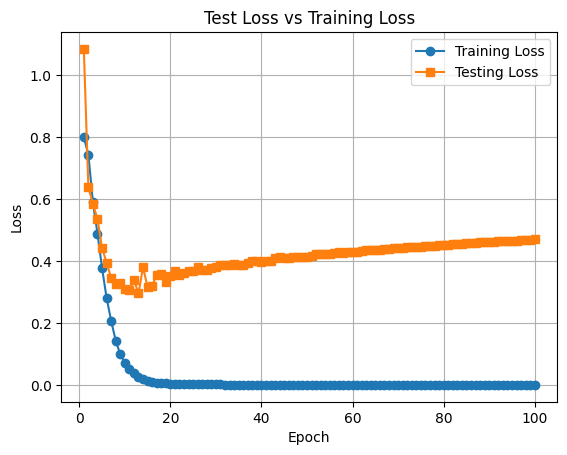

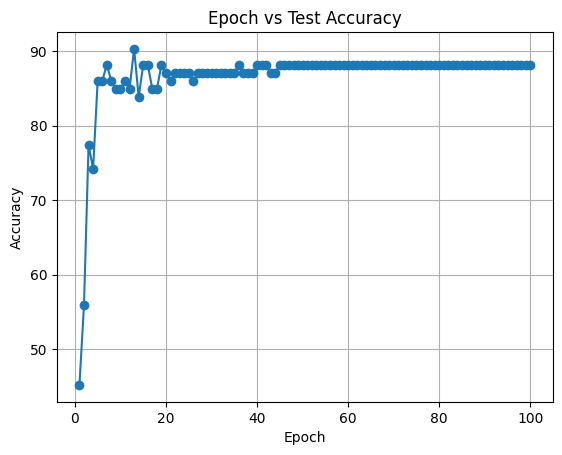

[0.8000273942947388,
 0.7433058977127075,
 0.5897715806961059,
 0.4885391592979431,
 0.37792870998382566,
 0.2809383988380432,
 0.20733350813388823,
 0.142858125269413,
 0.09915854185819625,
 0.07156403064727783,
 0.051928631216287616,
 0.037289677932858464,
 0.0244976244866848,
 0.01961793899536133,
 0.013846778124570847,
 0.00976053224876523,
 0.007059201877564192,
 0.0064704474993050095,
 0.005345469200983643,
 0.004451638786122203,
 0.0038087776862084865,
 0.0034270800184458493,
 0.0029752577189356088,
 0.002672031056135893,
 0.0024368222570046783,
 0.002357986569404602,
 0.002096026856452227,
 0.0018855715868994593,
 0.0017729658400639891,
 0.0016363981179893018,
 0.0015264877351000906,
 0.0014458340010605752,
 0.0013433889718726278,
 0.0012490738532505929,
 0.001197193469852209,
 0.0011264133034273982,
 0.001077230693772435,
 0.0010223931283690035,
 0.0009734834427945315,
 0.0008988692075945437,
 0.0008672378491610289,
 0.0008274818770587445,
 0.0007665206212550402,
 0.0007476651

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)


# Replace final FC for our task
num_classes = 2
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, num_classes)   # this layer is trainable by default

model = model.to(device)

# IMPORTANT: keep backbone in eval mode so BatchNorm running stats don't update
model.train()      # but we DO want the new head to train

# ----- Loss & optimizer (only update the new head) -----
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    [
        {"params": model.parameters(), "lr": 1e-5},
    ],
    weight_decay=1e-4,
)

train(100, model, train_loader, test_loader)